In [52]:
!curl -O 'https://raw.githubusercontent.com/Henrilin28/PUI2016_chl557/master/HW12_chl557/Assignment%201%20instructions.ipynb'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  191k  100  191k    0     0   464k      0 --:--:-- --:--:-- --:--:-- 2945k


# I prepared a dataset of hospital facilities Asthma dismissal records and uploaded it to Carto. 
## download it with an SQL query. Use the function I provide below.
## The name of the DB is NYCAsthmasDismissals
## *within the SQLquery* group the data by zipcode.

In [36]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import pylab as pl
from scipy.spatial.distance import pdist, squareform
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [2]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery  = 'SELECT COUNT(*), zipcodes FROM NYCAsthmasDismissals GROUP BY zipcodes'
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


In [3]:
len(facilities)

29

# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [4]:
path = os.getenv("PUIDATA")+ '/Census Business data/'

In [5]:
geonyc = gpd.read_file(path + "nyc-zip-code-tabulation-areas-polygons.geojson")
geonyc.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [6]:
geonyc.rename(index=str, columns={"postalCode": "zipcodes"}, inplace = True)
geonyc.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zipcodes
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [7]:
len(geonyc)

262

In [8]:
geonyc['zipcodes'] = pd.to_numeric(geonyc['zipcodes'])

In [9]:
# geonyc['zipcodes'] = pd.to_numeric

In [10]:
nyc_merged = geonyc.merge(facilities,on="zipcodes",how="inner")
nyc_merged.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zipcodes,count
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,926
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373,405
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,5.558777e+07,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ...",11375,246
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,14,Jamaica,NY,36,6.017758e+07,33123.943672,Queens,POLYGON ((-73.80904031652176 40.71991162363268...,11432,293
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,19,Richmond Hill,NY,36,3.202513e+07,31854.377541,Queens,POLYGON ((-73.83714702640651 40.70795706458588...,11418,567


In [11]:
len(nyc_merged)

29

# Create a 3xN numpy array with x-location, y-location, number of dismissals

In [12]:
nyc_merged["centroid"] = nyc_merged.centroid
nyc_merged

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zipcodes,count,centroid
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,926,POINT (-73.70344982649 40.74873122436191)
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373,405,POINT (-73.87842706401592 40.73885362850201)
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,5.558777e+07,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ...",11375,246,POINT (-73.84627891822217 40.72069287356896)
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,14,Jamaica,NY,36,6.017758e+07,33123.943672,Queens,POLYGON ((-73.80904031652176 40.71991162363268...,11432,293,POINT (-73.79305375491241 40.71576150247932)
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,19,Richmond Hill,NY,36,3.202513e+07,31854.377541,Queens,POLYGON ((-73.83714702640651 40.70795706458588...,11418,567,POINT (-73.83224696524333 40.69826195830777)
5,http://nyc.pediacities.com/Resource/PostalCode...,0,047,30,Brooklyn,NY,36,2.963100e+07,23899.442290,Brooklyn,POLYGON ((-73.93739763108535 40.67972992244106...,11213,376,POINT (-73.93632641492128 40.67115911980326)
6,http://nyc.pediacities.com/Resource/PostalCode...,0,047,31,Brooklyn,NY,36,4.197210e+07,26621.841578,Brooklyn,"POLYGON ((-73.9029413249695 40.67084010909053,...",11212,713,POINT (-73.91306557365552 40.66281929091006)
7,http://nyc.pediacities.com/Resource/PostalCode...,0,047,35,Brooklyn,NY,36,4.200274e+07,29464.195305,Brooklyn,POLYGON ((-73.98905871482322 40.64411926279492...,11219,421,POINT (-73.9966742379266 40.6327740236197)
8,http://nyc.pediacities.com/Resource/PostalCode...,0,005,41,Bronx,NY,36,5.526249e+07,35358.303139,Bronx,POLYGON ((-73.84463568041262 40.90475111227086...,10466,494,POINT (-73.84667017220015 40.89094194028763)
9,http://nyc.pediacities.com/Resource/PostalCode...,0,005,42,Bronx,NY,36,6.933617e+07,43944.750630,Bronx,POLYGON ((-73.88010836736842 40.89519554426504...,10467,2164,POINT (-73.87049649288559 40.87827796932308)


In [30]:
nyc_merged["x"] = nyc_merged.centroid.map(lambda p: p.x)
nyc_merged["y"] = nyc_merged.centroid.map(lambda p: p.y)

In [43]:
krigdata = nyc_merged.as_matrix(["x","y","count"])
krigdata

array([[  -73.70344983,    40.74873122,   926.        ],
       [  -73.87842706,    40.73885363,   405.        ],
       [  -73.84627892,    40.72069287,   246.        ],
       [  -73.79305375,    40.7157615 ,   293.        ],
       [  -73.83224697,    40.69826196,   567.        ],
       [  -73.93632641,    40.67115912,   376.        ],
       [  -73.91306557,    40.66281929,   713.        ],
       [  -73.99667424,    40.63277402,   421.        ],
       [  -73.84667017,    40.89094194,   494.        ],
       [  -73.87049649,    40.87827797,  2164.        ],
       [  -73.84080867,    40.84700067,  1699.        ],
       [  -73.89836132,    40.84576104,   822.        ],
       [  -73.90780308,    40.8301727 ,  1072.        ],
       [  -73.92373407,    40.82077879,  1698.        ],
       [  -73.92648445,    40.7715762 ,   281.        ],
       [  -73.82134259,    40.75124155,   641.        ],
       [  -73.92082096,    40.70396025,  1156.        ],
       [  -73.94241478,    40.7

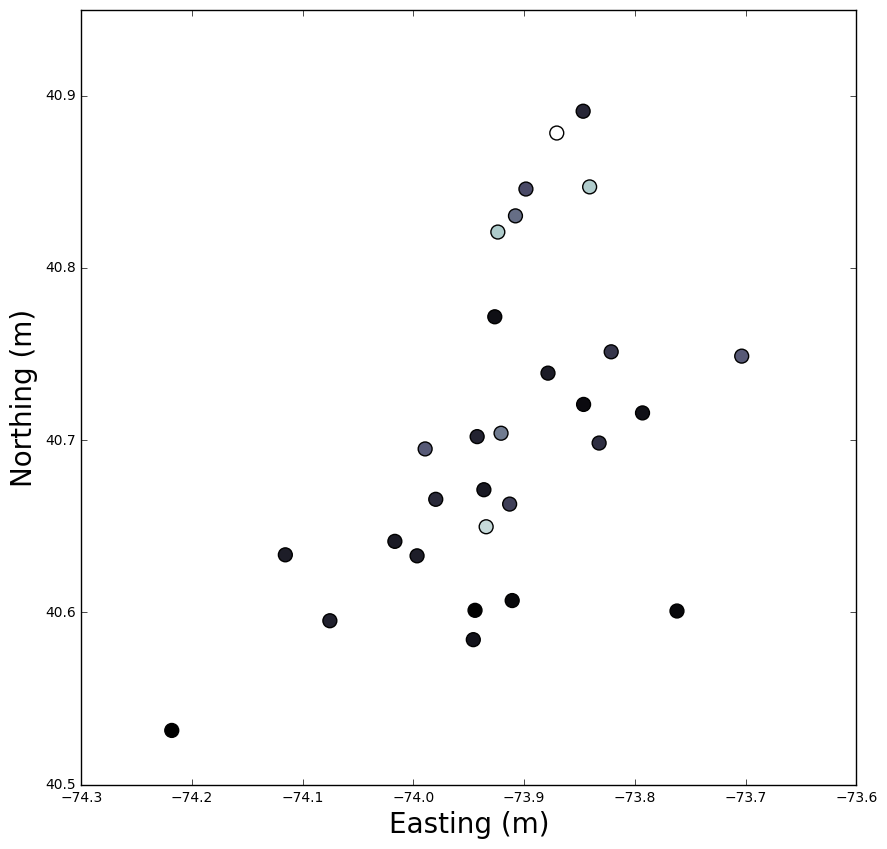

In [33]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.show()

# Create and try to model the semi-variogram as we did in class
# https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
# Explain what is going on

In [34]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [50]:
lag = 500
mysv = SV(krigdata, np.arange(1, 10000, lag), 10000)
mysv

# # lags in 500 meter increments from zero to 10,000
# hs = np.arange(0, 10500, lag)
# #mysv = SV( x, hs, bw )
# pl.figure(figsize=(8,8))
# pl.plot( mysv[0], mysv[1], '.-' )
# pl.xlabel('Lag [m]', fontsize=20)
# pl.ylabel('Semivariogram', fontsize=20)
# pl.title('Semivariogram\nasthma data, lag %dm'%lag, fontsize=20) 
# pl.show()

array([[  1.00000000e+00,   5.01000000e+02,   1.00100000e+03,
          1.50100000e+03,   2.00100000e+03,   2.50100000e+03,
          3.00100000e+03,   3.50100000e+03,   4.00100000e+03,
          4.50100000e+03,   5.00100000e+03,   5.50100000e+03,
          6.00100000e+03,   6.50100000e+03,   7.00100000e+03,
          7.50100000e+03,   8.00100000e+03,   8.50100000e+03,
          9.00100000e+03,   9.50100000e+03],
       [  2.96032007e+05,   2.96032007e+05,   2.96032007e+05,
          2.96032007e+05,   2.96032007e+05,   2.96032007e+05,
          2.96032007e+05,   2.96032007e+05,   2.96032007e+05,
          2.96032007e+05,   2.96032007e+05,   2.96032007e+05,
          2.96032007e+05,   2.96032007e+05,   2.96032007e+05,
          2.96032007e+05,   2.96032007e+05,   2.96032007e+05,
          2.96032007e+05,   2.96032007e+05]])

In [44]:
# different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

In [47]:
bw = 1000
pl.figure(figsize=(10,10))
sp = cvmodel( krigdata, model=spherical, 
             hs=np.arange(0,10000, 100 ), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
pl.plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram and model', fontsize=20) 

In [ ]:
#@Review:
# no rendered semi veriogram plot
#comment on what's happening, what you infer? See solution.